<a href="https://colab.research.google.com/github/darrencheninfo/ADS504_G1_Project/blob/modeling/modeling_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# -------------------------------------------------------------
# 0. Imports & data load
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# ---- Load the engineered features ----
df = pd.read_csv("/content/diabetes_features_engineered.csv")

# Identify the target column and survey-weight column -----------
TARGET_COL = "Diabetes_Comorbidity_Score"

WEIGHT_COL = "_LLCPWT" if "_LLCPWT" in df.columns else None   # BRFSS survey weight

y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

sample_weights = df[WEIGHT_COL] if WEIGHT_COL else None

In [8]:
# -------------------------------------------------------------
# 1. Audit: dtypes, missing, class balance
# -------------------------------------------------------------
print(df.dtypes.to_string())

missing = df.isna().mean().sort_values(ascending=False).round(3)
print("\nMissingness (top 15):")
print(missing.head(15))

print("\nTarget distribution:")
print(y.value_counts(normalize=True).sort_index().round(4))


Unnamed: 0                      int64
SEXVAR                        float64
GENHLTH                       float64
PHYSHLTH                      float64
POORHLTH                      float64
EXERANY2                      float64
FALL12MN                      float64
FALLINJ5                      float64
_URBSTAT                      float64
_IMPRACE                      float64
_AGE80                        float64
Diabetes_Comorbidity_Score    float64
Diabetic_Care_Score           float64
Disability_Score              float64
Proactive_Care_Score            int64
Access_to_Care_Score            int64
Alcohol_Abuse_Indicator       float64
Tobacco_Score                 float64
social_score                    int64
Marijuana_Score               float64
Cognitive_Score               float64
BMI_Value                     float64
BMI_Category                   object
Region                         object

Missingness (top 15):
FALLINJ5                   0.674
Alcohol_Abuse_Indicator    0.670

# Preprocessing pipeline with imputers (fixes PCA NaN error)

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Split feature types
numeric_cols     = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", categorical_pipe, categorical_cols),
    ],
    remainder="drop"
)



# PCA/t-SNE visuals on preprocessed matrix

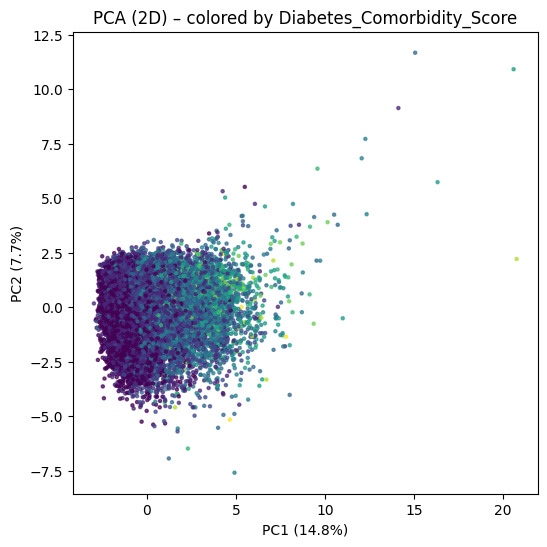

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


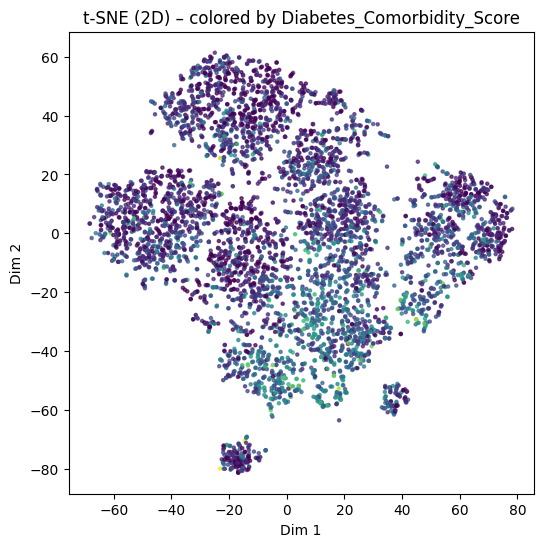

In [11]:

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Fit/transform once
X_proc = preprocess.fit_transform(X)

# Convert to dense for PCA if needed; PCA can take sparse but t-SNE wants dense
X_dense_for_tsne = X_proc.toarray() if hasattr(X_proc, "toarray") else np.asarray(X_proc)

# PCA (2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_dense_for_tsne)
plt.figure(figsize=(6,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=5, alpha=0.7)
plt.title("PCA (2D) – colored by Diabetes_Comorbidity_Score")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.show()

# t-SNE (2D) – subsample for speed if needed
subset = np.random.RandomState(42).choice(X_dense_for_tsne.shape[0], size=min(5000, X_dense_for_tsne.shape[0]), replace=False)
tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_dense_for_tsne[subset])
plt.figure(figsize=(6,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y.iloc[subset], s=5, alpha=0.7)
plt.title("t-SNE (2D) – colored by Diabetes_Comorbidity_Score")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.show()


 # Class imbalance check (multi-class)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
w_train = w_test = None
if WEIGHT_COL:
    w_train, w_test = df.loc[X_train.index, WEIGHT_COL], df.loc[X_test.index, WEIGHT_COL]


# Baseline Decision Tree (multi-class) with pipeline

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score

tree_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(
        max_depth=6,
        min_samples_leaf=50,
        class_weight="balanced",   # basic imbalance handling
        random_state=42
    ))
])

fit_kwargs = {}
if w_train is not None:
    fit_kwargs["clf__sample_weight"] = w_train

tree_pipe.fit(X_train, y_train, **fit_kwargs)
y_pred = tree_pipe.predict(X_test)

print("\n--- Decision Tree metrics ---")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Balanced Acc:", round(balanced_accuracy_score(y_test, y_pred), 3))
print(classification_report(y_test, y_pred, digits=3))


--- Decision Tree metrics ---
Accuracy: 0.243
Balanced Acc: 0.184
              precision    recall  f1-score   support

         0.0      0.413     0.584     0.484       940
         1.0      0.330     0.279     0.302      1187
         2.0      0.265     0.058     0.095       852
         3.0      0.192     0.009     0.018       529
         4.0      0.000     0.000     0.000       282
         5.0      0.059     0.139     0.083       137
         6.0      0.023     0.288     0.042        59
         7.0      0.009     0.050     0.015        20
         8.0      0.012     0.429     0.024         7
         9.0      0.000     0.000     0.000         1

    accuracy                          0.243      4014
   macro avg      0.130     0.184     0.106      4014
weighted avg      0.278     0.243     0.229      4014



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# LightGBM

In [16]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

lgbm_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LGBMClassifier(
        n_estimators=600,
        learning_rate=0.03,
        objective="multiclass",
        num_class=y.nunique(),
        class_weight="balanced",
        random_state=42
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Weighted multiclass AUC is fiddly; we’ll use macro-averaged AUC if proba available
def macro_auc(model, X_val, y_val):
    from sklearn.preprocessing import label_binarize
    y_proba = model.predict_proba(X_val)
    classes = np.sort(y.unique())
    y_true_binarized = label_binarize(y_val, classes=classes)
    return roc_auc_score(y_true_binarized, y_proba, average="macro", multi_class="ovr")

# Cross-validate with weights (fit_params)
fit_params = {}
if WEIGHT_COL:
    fit_params = {"clf__sample_weight": df[WEIGHT_COL]}

# Manual CV to compute macro AUC
scores = []
for tr_idx, va_idx in cv.split(X, y):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    fit_kwargs = {}
    if WEIGHT_COL:
        fit_kwargs["clf__sample_weight"] = df.iloc[tr_idx][WEIGHT_COL]
    lgbm_pipe.fit(X_tr, y_tr, **fit_kwargs)
    scores.append(macro_auc(lgbm_pipe, X_va, y_va))

print(f"\nLightGBM CV macro AUC: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# Final fit + test metrics
fit_kwargs = {}
if w_train is not None:
    fit_kwargs["clf__sample_weight"] = w_train
lgbm_pipe.fit(X_train, y_train, **fit_kwargs)

y_pred = lgbm_pipe.predict(X_test)
y_proba = lgbm_pipe.predict_proba(X_test)
print("\n--- LightGBM test metrics ---")
print("Accuracy:", accuracy_score(y_test, y_pred).round(3))
print("Balanced Acc:", balanced_accuracy_score(y_test, y_pred).round(3))
try:
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_test, classes=np.sort(y.unique()))
    print("Macro AUC:", roc_auc_score(y_true_bin, y_proba, average="macro", multi_class="ovr").round(3))
except Exception as e:
    print("AUC not available:", e)
print(classification_report(y_test, y_pred, digits=3))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 16055, number of used features: 34
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 16055, number of used features: 34
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 792
[LightGBM] [Info] Number of data points in the train set: 16055, number of used features: 34
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 16055, number of used features: 34
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 792
[LightGBM] [Info] Number of data points in the train set: 16056, number of used features: 34
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LightGBM CV macro AUC: 0.727 ± 0.031
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 16055, number of used features: 34
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- LightGBM test metrics ---


AttributeError: 'float' object has no attribute 'round'

old code

In [ ]:
# -------------------------------------------------------------
# 3. Baseline Decision Tree
# -------------------------------------------------------------
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, stratify=y, random_state=42
)

tree_pipe = Pipeline(
    steps=[
        ("prep", preprocess),
        ("clf", DecisionTreeClassifier(
            max_depth=5, min_samples_leaf=50,
            class_weight="balanced", random_state=42
        ))
    ]
)

tree_pipe.fit(X_train, y_train, clf__sample_weight=w_train if w_train is not None else None)
y_pred_tree = tree_pipe.predict(X_test)
y_prob_tree = tree_pipe.predict_proba(X_test)[:, 1]

print("\n--- Decision Tree metrics ---")
print("Accuracy:", accuracy_score(y_test, y_pred_tree).round(3))
print("ROC-AUC :", roc_auc_score(y_test, y_prob_tree).round(3))
print(classification_report(y_test, y_pred_tree))




In [ ]:
# -------------------------------------------------------------
# 4. LightGBM (gradient boosting)
# -------------------------------------------------------------
lgbm_pipe = Pipeline(
    steps=[
        ("prep", preprocess),
        ("clf", LGBMClassifier(
            n_estimators=500,
            learning_rate=0.03,
            max_depth=-1,
            num_leaves=31,
            objective="binary",
            class_weight="balanced",        # handles imbalance
            random_state=42
        ))
    ]
)

# 5-fold stratified CV with survey weights
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    lgbm_pipe, X, y, cv=cv, scoring="roc_auc",
    fit_params={"clf__sample_weight": sample_weights} if sample_weights is not None else None
)
print("\nLightGBM CV ROC-AUC:", cv_scores.mean().round(3), "±", cv_scores.std().round(3))

# Fit on full training split and report test metrics -----------
lgbm_pipe.fit(X_train, y_train, clf__sample_weight=w_train if w_train is not None else None)
y_pred_lgbm = lgbm_pipe.predict(X_test)
y_prob_lgbm = lgbm_pipe.predict_proba(X_test)[:, 1]

print("\n--- LightGBM test metrics ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm).round(3))
print("ROC-AUC :", roc_auc_score(y_test, y_prob_lgbm).round(3))
print(classification_report(y_test, y_pred_lgbm))